In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

import umap
import hdbscan

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
N_JOBS = int(
    os.getenv('NUM_CPUS', os.cpu_count())
)
N_JOBS

4

In [2]:
df = pd.read_pickle('data/EPMC/eye_in_new_keywords.pkl')
df.drop_duplicates(subset='pmid',inplace=True)
df.set_index('pmid',inplace=True)
print(len(df),'rows')
df.head()

409266 rows


,abstractText,authorList,chemicalList,citedByCount,doi,firstPublicationDate,grantsList,id,journalInfo,keywordList,meshHeadingList,pmcid,pubYear,title
pmid,,,,,,,,,,,,,,
30209082,To assess the prevalence and causes of vision ...,"[{'fullName': 'Kahloun R', 'firstName': 'Rim',...",NaN,0,10.1136/bjophthalmol-2018-312068,2018-09-12,NaN,30209082,"{'journalIssueId': 2723351, 'dateOfPublication...","[Cataract, epidemiology, Blindness, Vision Imp...",NaN,NaN,2018,Prevalence and causes of vision loss in North ...
29781739,"In developed countries, genetically inherited ...","[{'fullName': 'Yahalom C', 'firstName': 'Claud...",NaN,0,10.1080/13816810.2018.1474368,2018-05-21,NaN,29781739,"{'issue': '4', 'volume': '39', 'journalIssueId...","[Prevention, Genetic Counselling, Pgd, Inherit...",NaN,NaN,2018,Preimplantation genetic diagnosis as a strateg...
30092731,Systemic autoimmune diseases are associated wi...,"[{'fullName': 'Lin WV', 'firstName': 'W V', 'l...",NaN,0,10.1177/0961203318792365,2018-08-09,NaN,30092731,"{'journalIssueId': 2711754, 'dateOfPublication...","[Keratitis, systemic lupus erythematosus, Sjog...",NaN,NaN,2018,"Scleritis, keratitis, and orbital cellulitis: ..."
30096011,To assess the prevalence of the ocular manifes...,"[{'fullName': 'Dammacco R', 'firstName': 'Rosa...",NaN,0,10.1080/09273948.2018.1501495,2018-08-10,NaN,30096011,"{'journalIssueId': 2714262, 'dateOfPublication...","[Glucocorticoids, systemic lupus erythematosus...",NaN,NaN,2018,Ocular Involvement in Systemic Lupus Erythemat...
30270476,Optical coherence tomography (OCT) provides no...,"[{'fullName': 'Jiao H', 'firstName': 'Haihan',...",NaN,0,10.1111/cxo.12835,2018-10-01,"[{'grantId': 'APP1126540', 'agency': 'National...",30270476,"{'journalIssueId': 2732178, 'dateOfPublication...","[Cornea, Inflammation, Imaging, optical cohere...",NaN,NaN,2018,Anterior segment optical coherence tomography:...


In [3]:
abstracts = df.loc[~df['abstractText'].isnull(),'abstractText']

del df

abstracts = abstracts.dropna()

# remove missing/very short abstracts
abstracts = abstracts[abstracts.str.split(r'[^a-zA-Z]+').str.len()>10]
print(len(abstracts),'remaining abstracts')

# convert to lower case and remove digits and punctuation
abstracts = abstracts.str.lower()
abstracts = abstracts.str.replace(r'[^a-zA-Z]+',' ',regex=True)
abstracts = abstracts.str.strip()

pmids = abstracts.index
abstracts.head()

364989 remaining abstracts


pmid
30209082    to assess the prevalence and causes of vision ...
29781739    in developed countries genetically inherited e...
30092731    systemic autoimmune diseases are associated wi...
30096011    to assess the prevalence of the ocular manifes...
30270476    optical coherence tomography oct provides non ...
Name: abstractText, dtype: object

In [4]:
'''
stemmer = SnowballStemmer('english')

abstracts= abstracts.apply(lambda x : filter(None,x.split(" ")))
abstracts=abstracts.apply(lambda x : [stemmer.stem(y) for y in x])
abstracts=abstracts.apply(lambda x : " ".join(x))

del stemmer

abstracts.head()
'''

'\nstemmer = SnowballStemmer(\'english\')\n\nabstracts= abstracts.apply(lambda x : filter(None,x.split(" ")))\nabstracts=abstracts.apply(lambda x : [stemmer.stem(y) for y in x])\nabstracts=abstracts.apply(lambda x : " ".join(x))\n\ndel stemmer\n\nabstracts.head()\n'

In [5]:
try:
    lemma = WordNetLemmatizer()
except:
    import nltk
    nltk.download('wordnet')
    lemma = WordNetLemmatizer()

try:
    stop_words = stopwords.words('english')
except:
    import nltk
    nltk.download('stopwords')
    stop_words = stopwords.words('english')
    
abstracts= abstracts.str.split(' ')
abstracts=abstracts.apply(lambda x : [lemma.lemmatize(word) for word in x if word not in stop_words])
abstracts=abstracts.apply(lambda x : ' '.join(x))

del lemma

abstracts.head()

pmid
30209082    ass prevalence cause vision impairment north a...
29781739    developed country genetically inherited eye di...
30092731    systemic autoimmune disease associated ocular ...
30096011    ass prevalence ocular manifestation related di...
30270476    optical coherence tomography oct provides non ...
Name: abstractText, dtype: object

In [6]:
'''
tfidf = TfidfVectorizer(strip_accents='unicode', lowercase=True, stop_words='english', 
                        ngram_range=(1, 1), max_df=0.1, min_df=1, max_features=None, 
                        use_idf=True)

# 'fit' the vectorizer to the corpus
# this step automatically determins the vocabulary
tfidf.fit(abstracts)

print('size vocab:',len(tfidf.vocabulary_ ))
print('no. stop words:',len(tfidf.stop_words_))

# then 'transform' the corpus
# this computes the term frequency vectors
tfidf_vectors = tfidf.transform(abstracts)
features = tfidf.get_feature_names()
'''

"\ntfidf = TfidfVectorizer(strip_accents='unicode', lowercase=True, stop_words='english', \n                        ngram_range=(1, 1), max_df=0.1, min_df=1, max_features=None, \n                        use_idf=True)\n\n# 'fit' the vectorizer to the corpus\n# this step automatically determins the vocabulary\ntfidf.fit(abstracts)\n\nprint('size vocab:',len(tfidf.vocabulary_ ))\nprint('no. stop words:',len(tfidf.stop_words_))\n\n# then 'transform' the corpus\n# this computes the term frequency vectors\ntfidf_vectors = tfidf.transform(abstracts)\nfeatures = tfidf.get_feature_names()\n"

## Vectorise

In [7]:
# USE COUNT VECTORISER - tfidf not appropriate for LDA input?
# played with stop words and max_df

countvec = CountVectorizer(strip_accents='unicode', lowercase=True, stop_words='english', 
                           ngram_range=(1, 2), max_df=0.2, min_df=0.0005, max_features=None)

# 'fit' the vectorizer to the corpus
# this step automatically determins the vocabulary
countvec.fit(abstracts)

print('size vocab:',len(countvec.vocabulary_))
print('no. stop words:',len(countvec.stop_words_))

joblib.dump(countvec, 'data/CountVec.joblib') 

# then 'transform' the corpus
# this computes the term frequency vectors
countvec_vectors = countvec.transform(abstracts)
features = countvec.get_feature_names()

del abstracts

size vocab: 27509
no. stop words: 10227181


In [6]:
features

['aa',
 'aav',
 'aav vector',
 'ab',
 'ab interno',
 'abandoned',
 'abbott',
 'abbott medical',
 'abc',
 'abca',
 'abca gene',
 'abcc',
 'abcg',
 'abdomen',
 'abdominal',
 'abdominal pain',
 'abducens',
 'abducens nerve',
 'abduction',
 'aberrant',
 'aberrantly',
 'aberration',
 'aberration eye',
 'aberration hoas',
 'aberration measured',
 'aberrometer',
 'aberrometry',
 'ability',
 'ability detect',
 'ablated',
 'ablation',
 'ablation depth',
 'ablative',
 'able',
 'able detect',
 'able identify',
 'able induce',
 'abnormal',
 'abnormal eye',
 'abnormal finding',
 'abnormal retinal',
 'abnormal visual',
 'abnormality',
 'abnormality associated',
 'abnormality detected',
 'abnormality eye',
 'abnormality including',
 'abnormality observed',
 'abnormality patient',
 'abnormality present',
 'abnormality retinal',
 'abnormally',
 'abolish',
 'abolished',
 'abolishes',
 'abortion',
 'abrasion',
 'abrogated',
 'abrupt',
 'abscess',
 'absence',
 'absence presence',
 'absent',
 'absolute',
 

## LDA

In [7]:
lda = LatentDirichletAllocation(n_components=50,learning_method='online',verbose=1)
lda.fit(countvec_vectors) 
joblib.dump(lda, 'data/LDA.joblib') 

lda_vectors = lda.transform(countvec_vectors)

topics = pd.DataFrame(lda.components_,columns=features)
for key,topic in topics.iterrows():
    print('--------------------')
    print('TOPIC',key)
    print('--------------------')
    print(topic.sort_values(ascending=False).head(10))
    
del countvec_vectors

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
--------------------
TOPIC 0
--------------------
risk              53118.238889
rb                29190.290635
factor            27603.704423
incidence         20674.069600
risk factor       18202.546820
retinoblastoma    15202.021489
rate              11140.908204
record             8617.963233
common             8007.049779
period             7877.990042
Name: 0, dtype: float64
--------------------
TOPIC 1
--------------------
image          36935.256785
test           26024.302967
based          18093.476657
head           16782.188385
sensitivity    13643.555279
high           13557.161660
detection      13330.290310
time           13156.990839
data           12874.313943
analysis       11563.32

growth                28831.543407
injection             25164.882272
vegf                  21465.704434
growth factor         16784.207686
factor                16025.693428
endothelial           13061.278749
vascular              12595.045478
angiogenesis           9422.978298
neovascularization     9148.093871
intravitreal           8935.732487
Name: 39, dtype: float64
--------------------
TOPIC 40
--------------------
subject          60678.383644
control          28754.195983
measurement      25801.988062
correlation      24892.450471
healthy          24564.819491
normal           23837.588143
significantly    22685.632415
value            20476.073727
measured         19488.460805
compared         17563.915687
Name: 40, dtype: float64
--------------------
TOPIC 41
--------------------
related                 19331.789873
amd                     19323.220315
age related             14276.966804
cost                    13146.228906
degeneration            12620.627731
macular      

In [19]:
topics['glaucoma'].sort_values(ascending=False).head(10)

0         0.020000
1         0.020000
2         0.020000
3         0.020000
4         0.020000
5         0.020000
6         0.020000
7         0.020000
8         0.020000
9         0.020000
10        0.020000
11        0.020000
12        0.020000
13     8192.096185
14        0.020000
15        0.020000
16     5149.448489
17        0.020000
18        0.020000
19        0.020000
20        0.020000
21    10800.436865
22        0.020000
23        4.636956
24        0.020000
25        0.020000
26        0.020000
27        0.020000
28        0.020000
29        0.020000
30        0.020000
31        0.020000
32        0.020000
33        0.020000
34        0.020000
35        0.020000
36        0.020000
37        0.020000
38        0.020000
39        0.020000
40        0.020000
41    11951.314741
42        0.020000
43        0.020000
44        0.020000
45        0.020000
46        0.020000
47        0.020000
48        0.020000
49        0.020000
Name: macular, dtype: float64

In [9]:
umapper = umap.UMAP()

X_umap = umapper.fit_transform(lda_vectors)

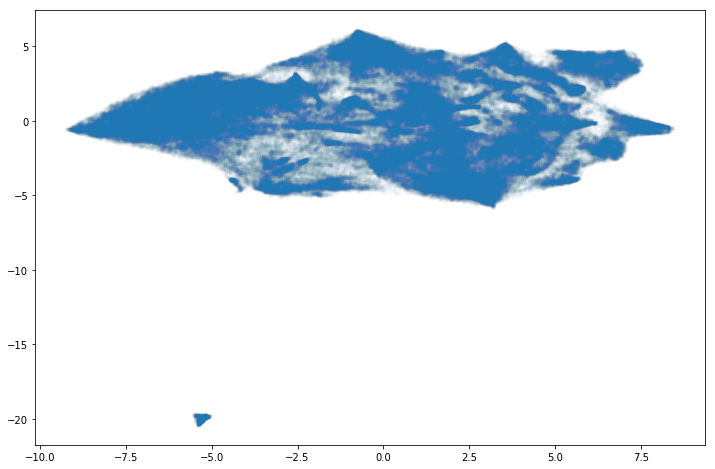

In [10]:
plt.figure(figsize=(12,8))
plt.scatter(X_umap[:,0],X_umap[:,1],marker='.',alpha=0.01)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.038263,-0.048988,0.283348,-0.025441,-0.032321,0.000673,-0.009240,-0.041008,-0.056978,-0.061552,...,-0.046865,-0.003910,0.129891,-0.021035,-0.076790,-0.036194,0.008412,0.052178,0.000989,0.117476
1,0.003211,-0.058745,-0.160287,-0.013627,-0.037323,-0.044741,-0.045561,-0.028539,0.165149,-0.031535,...,-0.094210,-0.014016,0.680614,0.069847,-0.181102,0.097663,0.009329,0.007405,-0.045173,0.037504
2,-0.016133,0.200732,-0.195004,-0.033354,0.008018,-0.004136,-0.033536,0.000535,-0.122140,0.072140,...,0.037457,0.020775,0.215155,-0.039928,-0.003528,-0.049802,0.005782,0.042952,0.294658,0.602070
3,0.040544,-0.070604,0.000467,-0.018648,0.025059,0.025887,0.017950,0.062150,-0.167813,0.040018,...,0.068366,0.016172,0.633936,-0.086817,0.166629,-0.092275,-0.004722,-0.053141,-0.113896,-0.380871
4,-0.006241,0.083738,0.620465,0.031479,0.068848,0.008054,0.059014,0.061524,0.027834,0.050051,...,0.161887,0.001819,0.017000,0.001207,-0.171663,-0.019442,0.032335,0.039612,0.088354,-0.294304


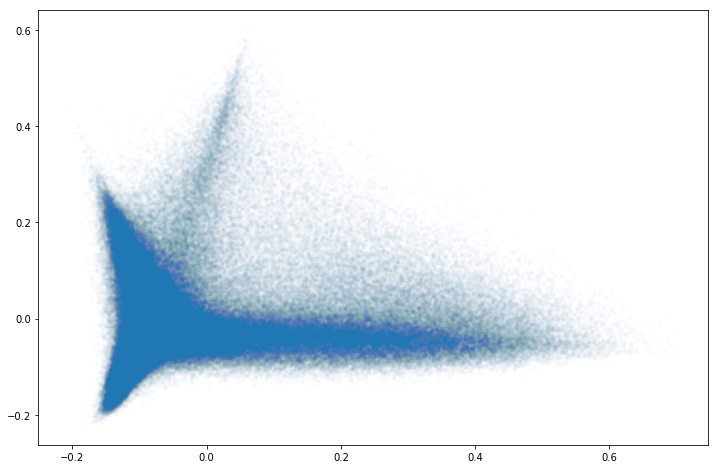

In [11]:
pca = PCA()
X_pca = pca.fit_transform(lda_vectors)

plt.figure(figsize=(12,8))
plt.scatter(X_pca[:,0],X_pca[:,1],marker='.',alpha=0.01)

pca_comps = pd.DataFrame(pca.components_)
pca_comps.head()

No. clusters: 2


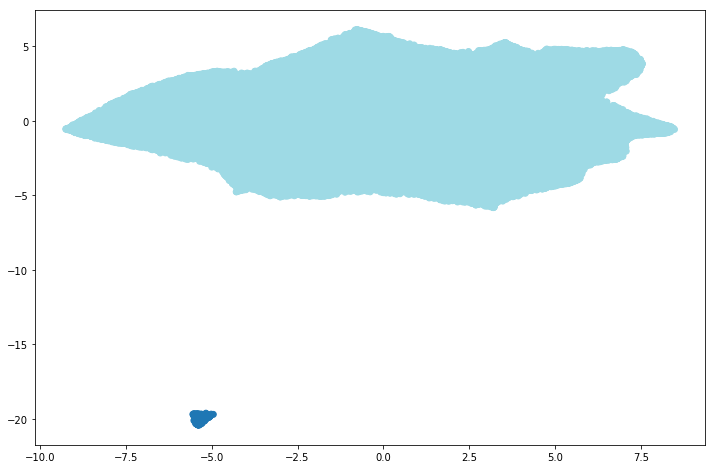

In [25]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)

clusters = clusterer.fit_predict(X_umap)
#clusters = clusterer.fit_predict(lda_vectors)

print('No. clusters:',len(np.unique(clusters)))

plt.figure(figsize=(12,8))
plt.scatter(X_umap[clusters==-1,0], X_umap[clusters==-1,1], c='k', marker='x', alpha=0.1)
plt.scatter(X_umap[clusters>-1,0], X_umap[clusters>-1,1], 
            c=clusters[clusters>-1], cmap='tab20',alpha=1)


In [26]:
for c in np.unique(clusters[clusters>-1]):
    print('---------------------------')
    print('CLUSTER',c)
    print('---------------------------')
    #[print(str(title)+'\n') for title in df.loc[clusters==c,'abstractText']]
    sum_lda = np.mean(lda_vectors[clusters==c,:],axis=0)
    print(pd.Series(sum_lda).sort_values(ascending=False).head())
    
    print('UMAP_0 =',np.mean(X_umap[clusters==c,0]))
    print('UMAP_1 =',np.mean(X_umap[clusters==c,1]))
    #for row in tfidf_vectors[clusters==c,:].toarray():
    #    print(
    #    pd.DataFrame(
    #        {'Terms': features, 'Term Frequency (weighted)': row}
    #    ).sort_values(by='Term Frequency (weighted)',ascending=False).head(10)['Terms'].values#to_string(index=False)
    #    )
    #    #print('\n')


---------------------------
CLUSTER 0
---------------------------
42    0.652576
17    0.036329
49    0.022222
36    0.020117
18    0.015250
dtype: float64
UMAP_0 = -5.302172
UMAP_1 = -19.961203
---------------------------
CLUSTER 1
---------------------------
33    0.073225
49    0.059771
2     0.041311
30    0.040620
27    0.032821
dtype: float64
UMAP_0 = 0.039922718
UMAP_1 = 0.1872795


In [27]:
lda_vectors

array([[1.24223602e-04, 1.26905953e-02, 1.24223602e-04, ...,
        1.24223602e-04, 1.24223602e-04, 1.24223602e-04],
       [9.10327632e-03, 1.15606936e-04, 1.15606936e-04, ...,
        1.15606936e-04, 1.15606936e-04, 3.67664660e-02],
       [2.29885057e-04, 2.29885057e-04, 2.29885057e-04, ...,
        2.10156691e-02, 2.29885057e-04, 2.29885057e-04],
       ...,
       [3.84615385e-04, 3.84615385e-04, 6.96520453e-02, ...,
        3.84615385e-04, 2.26797828e-02, 3.84615385e-04],
       [4.27605152e-02, 1.01010101e-04, 2.66640447e-01, ...,
        8.95810802e-03, 1.01010101e-04, 4.64020389e-02],
       [1.90848797e-02, 9.85221675e-05, 1.71401596e-01, ...,
        9.98293796e-03, 2.37314329e-02, 1.42532461e-02]])

In [ ]:
df = pd.read_pickle('data/EPMC/eye_in_new_keywords.pkl')
df.drop_duplicates(subset='pmid',inplace=True)
df.set_index('pmid',inplace=True)
print(len(df),'rows')
df.head()


In [18]:
'''
with pd.option_context('display.max_colwidth', -1):
    display(abstracts[clusters==4])
'''

pmid
29226476    Cornea is a clear outermost layer of the eye which enables transmission of light onto the retina. The transparent corneal epithelium is regenerated by limbal stem cells (LSCs), whose loss/dysfunction results in LSCs deficiency (LSCD). Ex vivo expansion of autologous LSCs obtained from patient's healthy eye followed by transplantation onto the LSCs damaged/deficient eye, has provided a successful treatment for unilateral LSCD. However, this is not applicable to patient with total bilateral LSCD, where LSCs are lost/damaged from both eyes. We investigated the potential of human induced pluripotent stem cell (hiPSC) to differentiate into corneal epithelial-like cells as a source of autologous stem cell treatment for patients with total bilateral LSCD. Our study showed that combined addition of bone morphogenetic protein  (BMP), all trans-retinoic acid and epidermal growth factor for the first  days of differentiation followed by cell-replating on collagen-IV-coated surfac

In [19]:
'''
lda_df = pd.DataFrame(lda_vectors,index=abstracts.index)

abstracts.loc[lda_df.sort_values(by=14,ascending=False).head(10).index].tolist()
'''

'\nlda_df = pd.DataFrame(lda_vectors,index=abstracts.index)\n\nabstracts.loc[lda_df.sort_values(by=14,ascending=False).head(10).index].tolist()\n'